## Import libraries

In [9]:
import torch
from spikingjelly.activation_based import neuron, functional
from spikingjelly import visualizing
from matplotlib import pyplot as plt

# Spiking Neuron Modules

- In SpikingJelly, we define the spiking neuron as the neuron that can only output spikes (or tensor whose element can only be 0 or 1).
- The network which uses spiking neurons is the Spiking Neural Network (SNN).
- Many frequently-used spiking neurons are defined in `spikingjelly.activation_based.neuron`.

In [2]:
if_layer = neuron.IFNode() # IF Neuron

## Parematers of a neuron
- **v_threshold** – threshold of this neurons layer.
- **v_reset** – reset voltage of this neurons layer. If not `None`, the neuron’s voltage will be set to **v_reset** after firing a spike. If `None`, the neuron’s voltage will subtract **v_threshold** after firing a spike.
- **surrogate_function** – the function for calculating surrogate gradients of the heaviside step function in backward.
- In most of the neurons layer in `spikingjelly.activation_based.neuron.IFNode`, the number of neurons is defined by the shape of input after this layer is initialized or `reset()`.

Similar to RNN cells, the spiking neuron is stateful (or has memory). The state of spiking neurons is the membrane potentials $V[t]$. All neurons in `spikingjelly.activation_based.neuron` have the attribute `v`.

In [3]:
print(if_layer.v) # membrane potential

0.0


We can find that `if_layer.v` is 0.0 because we have not given the neurons layer any input. Let us give different inputs and check the `v.shape`. We can find that it is the same with the input:

In [4]:
x = torch.rand(size=[2, 3])
if_layer(x)
print(f'x.shape={x.shape}, if_layer.v.shape={if_layer.v.shape}') # x.shape=torch.Size([2, 3]), if_layer.v.shape=torch.Size([2, 3])

if_layer.reset() # Reset neuron

x = torch.rand(size=[4, 5, 6])
if_layer(x)
print(f'x.shape={x.shape}, if_layer.v.shape={if_layer.v.shape}') # x.shape=torch.Size([4, 5, 6]), if_layer.v.shape=torch.Size([4, 5, 6])
if_layer.reset()

x.shape=torch.Size([2, 3]), if_layer.v.shape=torch.Size([2, 3])
x.shape=torch.Size([4, 5, 6]), if_layer.v.shape=torch.Size([4, 5, 6])


**Note that the spiking neurons are stateful. So, we must call `reset()` before we give a new input sample to the spiking neurons.**

## Charging equations

### IF neuron

In [5]:
def neuronal_charge(self, x: torch.Tensor):
    self.v = self.v + x

Firing spike will consume the accumulated potential, and make the potential decrease instantly, which is the neuronal reset. In SNN, there are two kinds of reset:
1. **Hard reset**: the membrane potential will be set to the reset voltage after firing: $V[t] = V_{reset}$
2. **Soft reset**: the membrane potential will decrease the threshold potential after firing: $V[t] = V[t] - V_{threshold}$
We can find that the neuron that uses soft reset does not need the attribute $V_{reset}$. The default value of `v_reset` in the `__init__` function of `spikingjelly.activation_based.neuron` is 1.0 and the neuron will use hard reset by default. If we set `v_reset = None`, then the neuron will use the soft reset.

## Three equations for describing spiking neurons
Now we can use the three equations: *neuronal charge*, *neuronal fire*, and *neuronal reset*, to describe all kinds of spiking neurons:
$$
\begin{aligned}
H[t] &= f(V[t-1],X[t])\\
S[t] &= \Theta(H[t] - V_{threshold})
\end{aligned}
$$
where $\Theta(x)$ is the `surrogate_function` in the parameters of `__init__`.  $\Theta(x)$ is the heaviside step function:
$$
\Theta(x) = \Bigg\{\begin{matrix}
1, & x\geq0\\
0, & x<0
\end{matrix}
$$
The hard reset equation is:
$$V[t] = H[t](1-S[t]) + V_{reset}S[t]$$
The soft reset equation is:
$$V[t] = H[t]- V_{threshold}S[t]$$

where $X[t]$ is the external input. To avoid confusion, we use $H[t]$ to represent the membrane potential after neuronal charging but before neuronal firing. $V[t]$ is the membrane potential after neuronal firing. $f(V[t-1], X[t])$ is the neuronal charging function, and is different for different neurons.

## Simulation
Now let us give inputs to the spiking neurons step-by-step, check the membrane potential and output spikes, and plot them. The input has `shape=[1]`. So, there is only 1 neuron. Its membrane potential and output spikes are:

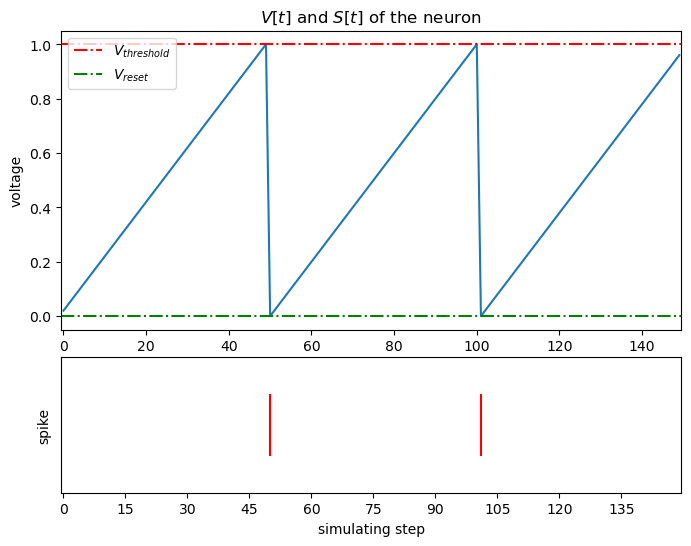

In [6]:
if_layer.reset()

x = torch.as_tensor([0.02])
T = 150
s_list = []
v_list = []

for t in range(T):
    s_list.append(if_layer(x))
    v_list.append(if_layer.v)

dpi = 100
figsize = (8,6)

visualizing.plot_one_neuron_v_s(torch.cat(v_list).numpy(), torch.cat(s_list).numpy(), v_threshold=if_layer.v_threshold,
                                v_reset=if_layer.v_reset,
                                figsize=figsize, dpi=dpi)
plt.show()

Reset the neurons layer, and give the input with `shape=[32]`. Then we can check the membrane potential and output spikes of these 32 neurons:

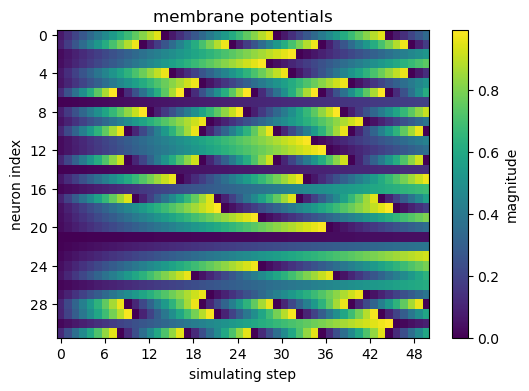

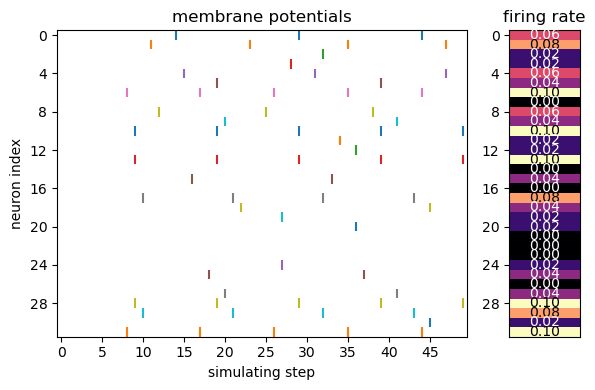

In [7]:
if_layer.reset()
T = 50
x = torch.rand([32]) / 8.
s_list = []
v_list = []
for t in range(T):
    s_list.append(if_layer(x).unsqueeze(0))
    v_list.append(if_layer.v.unsqueeze(0))

s_list = torch.cat(s_list)
v_list = torch.cat(v_list)

figsize = (6, 4)
dpi = 100
visualizing.plot_2d_heatmap(array=v_list.numpy(), title='membrane potentials', xlabel='simulating step',
                            ylabel='neuron index', int_x_ticks=True, x_max=T, figsize=figsize, dpi=dpi)


visualizing.plot_1d_spikes(spikes=s_list.numpy(), title='membrane potentials', xlabel='simulating step',
                        ylabel='neuron index', figsize=figsize, dpi=dpi)

plt.show()

## Step mode and backend
In the above codes, we use the single-step mode. By setting step_mode, we can switch to multi-step easily:

In [15]:
if_layer = neuron.IFNode(step_mode='s')
T, N = 8, 2
x_seq = torch.rand([T, N])
y_seq = functional.multi_step_forward(x_seq, if_layer)
print(y_seq.shape) # y_seq.shape = torch.Size([8, 2])

if_layer.reset() # Reset neuron

if_layer.step_mode = 'm'
y_seq = if_layer(x_seq)
print(y_seq.shape) # y_seq.shape = torch.Size([8, 2])

if_layer.reset() # Reset neuron

torch.Size([8, 2])
torch.Size([8, 2])


## CuPy backend

In [17]:
if_layer = neuron.IFNode()
print(f'if_layer.backend={if_layer.backend}')

print(f'step_mode={if_layer.step_mode}, supported_backends={if_layer.supported_backends}') # step_mode=s, supported_backends=('torch',)

if_layer.step_mode = 'm'
print(f'step_mode={if_layer.step_mode}, supported_backends={if_layer.supported_backends}') # step_mode=m, supported_backends=('torch', 'cupy')

device = 'cuda:0'
if_layer.to(device)
if_layer.backend = 'cupy'  # switch to the cupy backend
print(f'if_layer.backend={if_layer.backend}')
# if_layer.backend=cupy

x_seq = torch.rand([8, 4], device=device)
y_seq = if_layer(x_seq)
if_layer.reset()

if_layer.backend=torch
step_mode=s, supported_backends=('torch',)
step_mode=m, supported_backends=('torch', 'cupy')
if_layer.backend=cupy


## Custom Spiking Neurons

 `SpikingJelly` uses three equations: **neuronal change**, **neuronal fire**, and **neuronal reset**, to describe all kinds of spiking neurons. We can find the corresponding codes in `BaseNode`. The forward of single-step, which is the `single_step_forward` function, is composed of the three equations:

In [18]:
# spikingjelly.activation_based.neuron.BaseNode
def single_step_forward(self, x: torch.Tensor):
    self.neuronal_charge(x)
    spike = self.neuronal_fire()
    self.neuronal_reset(spike)
    return spike

`neuronal_fire` and `neuronal_reset` are same for most spiking neurons, and are defined by `BaseNode`. The difference of neurons are `__init__` and `neuronal_charge` functions. Hence, if we want to implement a new kind of spiking neuron, we only need to change the `__init__` and `neuronal_charge` functions.

## Square-Integrated-and-Fire neuron
Neuronal charge equation:
$$V[t] = f(V[t-1], X[t]) = V[t-1] + X[t]^2$$

In [20]:
class SquareIFNode(neuron.BaseNode):
    def neuronal_charge(self, x: torch.Tensor):
        self.v = self.v + x**2


`BaseNode` is inherited from `MemoryModule`, which uses `for t in range(T)` to call single-step forward function to implement the multi-step forward by default. So, after we define the `neuronal_charge`, then `single_step_forward` is completed, and `multi_step_forward` is also completed.

Use our `SquareIFNode` to implement the single/multi-step forward:

In [21]:
sif_layer = SquareIFNode()

T, N = 4, 1
x_seq = torch.rand([T, N])
print(f'x_seq={x_seq}')

for t in range(T):
    yt = sif_layer(x_seq[t])
    print(f'sif_layer.v[{t}]={sif_layer.v}')

sif_layer.reset() ## Reset neuron

sif_layer.step_mode = 'm'
y_seq = sif_layer(x_seq)
print(f'y_seq={y_seq}')

sif_layer.reset() ## Reset neuron



x_seq=tensor([[0.1607],
        [0.7598],
        [0.4069],
        [0.6690]])
sif_layer.v[0]=tensor([0.0258])
sif_layer.v[1]=tensor([0.6031])
sif_layer.v[2]=tensor([0.7687])
sif_layer.v[3]=tensor([0.])
y_seq=tensor([[0.],
        [0.],
        [0.],
        [1.]])
